In [105]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import copy

In [106]:

class DigitsDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx],self.y[idx]

In [107]:
#   The input size is 64 (8x8 images),
#  the hidden layer will hs 32 neurons 
#  and the output layer will have 10 neurons (for digits 0-9). 
#  a ReLU activation function between the layers.
class SimpleNet(nn.Module):
    def __init__(self):
        super(SimpleNet, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(64, 32),  # Input to hidden layer
            nn.ReLU(),          # Activation function
            nn.Linear(32, 10)   # Hidden to output layer
        )

    def forward(self, x):
        return self.model(x)

In [108]:
def train(model, dataloader, criterion, optimizer, device):
    model.train()  # prepare models for training
    running_loss = 0.0 # the total loss on all the samples
    running_corrects = 0 # how many corect predictions
    total_samples = 0  # how many samples had pass trough the NN


    for inputs, labels in dataloader:  # it passes to each batch of the dataloder
        inputs, labels = inputs.to(device) ,labels.to(device)
        y_logits=model(inputs)
        loss=criterion(y_logits,labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
         
        _, preds = torch.max(y_logits, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += (preds == labels).sum()
        total_samples +=  inputs.size(0)
        

    epoch_loss = running_loss/ total_samples
    epoch_acc = running_corrects.double() / total_samples
    return epoch_loss, epoch_acc.item()

def validate(model, dataloader, criterion, device):
    model.eval()  # prepare model vor evaluation
    running_loss = 0.0
    running_corrects = 0
    total_samples = 0

    with torch.inference_mode():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            _, preds = torch.max(outputs, 1)
            running_loss += loss.item() * inputs.size(0)
            running_corrects += (preds == labels).sum()
            total_samples += inputs.size(0)
            
    epoch_loss = running_loss / total_samples
    epoch_acc = running_corrects.double() / total_samples
    return epoch_loss, epoch_acc.item()

In [ ]:
# --- Prepare the Dataset ---
num_classes = 10
digits = load_digits(n_class=num_classes)
X, y = digits.data, digits.target

# Data spliting into training and validation sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.333333, random_state=42)

#  PyTorch datasets(alll the data that will be used ) 

train_dataset = DigitsDataset(X_train, y_train)
val_dataset = DigitsDataset(X_val, y_val)
test_dataset = DigitsDataset(X_test, y_test)

#  Pytorch dataloaders( splits the data into batches( only one batch will pass each time through the NN))
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# --- Model, Loss, and Optimizer Setup ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") ## make the device the GPU
model = SimpleNet().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

# --- Training Loop ---
num_epochs = 100
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

# The model with the bas acc
best_val_acc = 0.0
best_model_state = None
best_epoch = 0

for epoch in range(num_epochs):
    train_loss, train_acc = train(model, train_loader, criterion, optimizer, device)
    val_loss, val_acc = validate(model, val_loader, criterion, device)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_model_state = copy.deepcopy(model.state_dict())
        best_epoch = epoch+1

    print(f"Epoch {epoch+1}/{num_epochs} | "
          f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | "
          f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")

# Evaluate on test set
test_loss, test_acc = validate(model, test_loader, criterion, device)
print(f"\n Last model Test Loss: {test_loss:.4f} |  Test Accuracy: {test_acc:.4f}")

# Validation of the best model on the testing data:
model.load_state_dict(best_model_state)

print(f"\n The {best_epoch}th epoch is the one with the best acc")

# Evaluate on Validation set
val_loss, val_acc = validate(model, val_loader, criterion, device)
print(f" Best epoch Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")

# Evaluate on test set
test_loss, test_acc = validate(model, test_loader, criterion, device)
print(f" Best epoch Test Loss: {test_loss:.4f} |  Test Accuracy: {test_acc:.4f}")




Epoch 1/100 | Train Loss: 1.6639 | Train Acc: 0.5004 | Val Loss: 0.9007 | Val Acc: 0.7833
Epoch 2/100 | Train Loss: 0.6393 | Train Acc: 0.8520 | Val Loss: 0.4554 | Val Acc: 0.9000
Epoch 3/100 | Train Loss: 0.3832 | Train Acc: 0.9109 | Val Loss: 0.3302 | Val Acc: 0.9278
Epoch 4/100 | Train Loss: 0.2816 | Train Acc: 0.9292 | Val Loss: 0.2536 | Val Acc: 0.9472
Epoch 5/100 | Train Loss: 0.2258 | Train Acc: 0.9467 | Val Loss: 0.3209 | Val Acc: 0.9028
Epoch 6/100 | Train Loss: 0.1946 | Train Acc: 0.9523 | Val Loss: 0.2088 | Val Acc: 0.9444
Epoch 7/100 | Train Loss: 0.1774 | Train Acc: 0.9531 | Val Loss: 0.2391 | Val Acc: 0.9278
Epoch 8/100 | Train Loss: 0.1505 | Train Acc: 0.9658 | Val Loss: 0.1778 | Val Acc: 0.9444
Epoch 9/100 | Train Loss: 0.1356 | Train Acc: 0.9658 | Val Loss: 0.1870 | Val Acc: 0.9472
Epoch 10/100 | Train Loss: 0.1277 | Train Acc: 0.9706 | Val Loss: 0.1465 | Val Acc: 0.9611
Epoch 11/100 | Train Loss: 0.1162 | Train Acc: 0.9753 | Val Loss: 0.1411 | Val Acc: 0.9583
Epoch 12

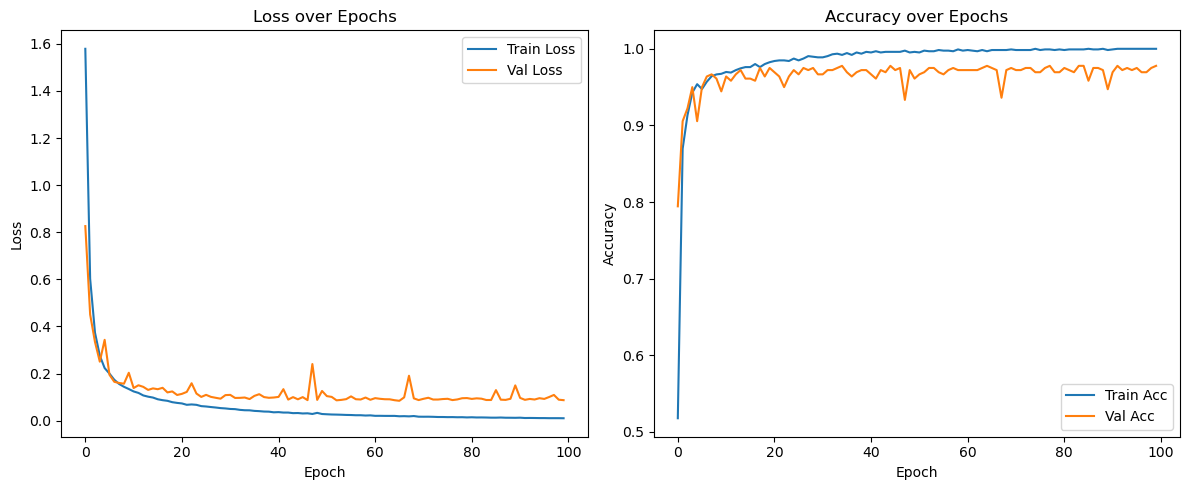

In [110]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss over Epochs')
plt.legend()


plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Acc')
plt.plot(val_accuracies, label='Val Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy over Epochs')
plt.legend()

plt.tight_layout()
plt.show()

In [111]:
import random
def plot_predictions(model, dataset, device, n_rows=2, n_cols=5, show_true=True):

    model.eval()
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols*2, n_rows*2))
    axes = axes.flatten()

    for i in range(n_rows * n_cols):
        idx = random.randint(0, len(dataset) - 1)
        x, y_true = dataset[idx]
        x_input = x.unsqueeze(0).to(device)  # shape: [1, 64]
        
        with torch.inference_mode():
            y_logits = model(x_input)
            y_pred = torch.argmax(y_logits, dim=1).item()

        # Reshape and plot image
        axes[i].imshow(x.view(8, 8).cpu(), cmap="gray_r")
        title = f"Pred: {y_pred}"
        if show_true:
            title += f"\nTrue: {y_true}"
        axes[i].set_title(title, fontsize=10)
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

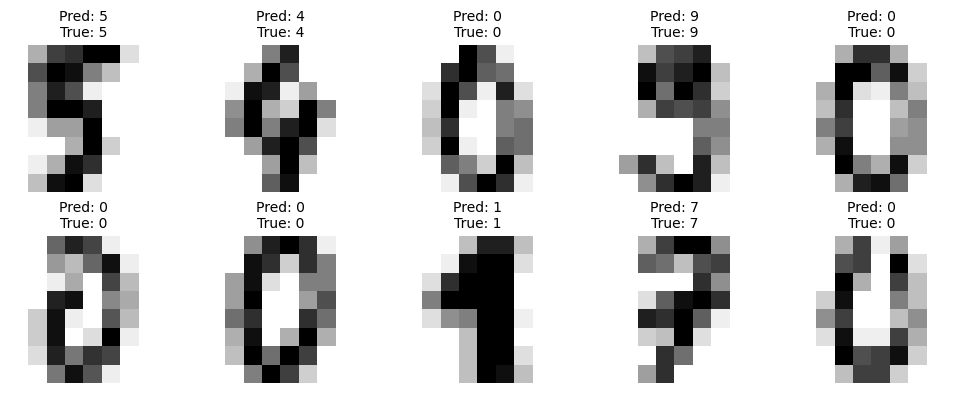

In [112]:
plot_predictions(model, test_dataset, device, n_rows=2, n_cols=5)
